# DSCI100 Final Project Report 

###  By Pouya Khoshnavazi, Tom Shi, Ege Taslicay, Rudra Patel

## Section 1 - Introduction

We will begin by loading in the libraries we need for our wrangling and predictions.

In [4]:
library(tidyverse) 
library(repr)
library(lubridate)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(hms)

**Background Information:**

This project report uses 2 datasets extracted from the Plaicraft project at UBC. We have one data set with information about players which are observations and another with information about play sessions. 

PlaiCraft is a minecraft server setup by UBC to gather data on human play sessions. 

We will use these 2 datasets to make a prediction that will help us answer our predictive question.


**Question:**

Our specific question is whether a player's age and experience level can accurately predict a player's total played hours using knn-regression to obtain players that contribute the largest amount of data.

**Data Description**

The data for this project consists of two files: one for player data and one for session data.

**Players File (players.csv):**
- **Number of observations / Rows**: 196
- **Number of variables / Columns**: 9
- **Variables**:
  - **experience**: Categorical, indicating player’s experience level (e.g., Beginner, Pro).
  - **subscribe**: Categorical, indicating email subscription status.
  - **hashedEmail**: Unique hashed identifier for each players email.
  - **played_hours**: Numerical, total hours played.
  - **name**: Player’s name.
  - **gender**: Categorical (e.g., Male, Female) players gender.
  - **age**: Numeric, player’s age.
  - **individualId**: Empty column.
  - **organizationName**: Empty column.

**Sessions File (sessions.csv):**
- **Number of observations / Rows**: 1,535
- **Number of variables / Columns**: 5
- **Variables**:
  - **hashedEmail**: Hashed identifier linking to players.
  - **start_time**: Date, session start time.
  - **end_time**: Date, session end time.
  - **original_start_time**: Unix timestamp for session start.
  - **original_end_time**: Unix timestamp for session end.

**Potential Issues**:
- **Missing data**: Some cells may be empty; `individualId` and `organizationName` are empty.
- **Unix Time**: May need conversion for better usability of some variables or removal because of redundancy.


## Section 2 - Methods and results

We started by setting a seed (2020) for reproducibility to ensure consistent results and then read in the two datasets, player_data and session_data, using read_csv. 

In player_data, we cleaned the data by selecting only the relevant columns, including hashedEmail, played_hours, name, gender, age, and experience, and we "removed" the empty columns of individualId and
organizationName by not selecting them. 

To facilitate analysis, we created a new column, experience_num, which converts the textual experience levels (e.g., Beginner, Amateur, Regular) into corresponding numeric values, which will **allow us to use it in later predictive models.** We can have experience as a numerical value since greater experience (e.g. Pro) demonstrates some increase from previous experience levels, it is "larger" in a sense. 

For session_data, we focused on reformatting and improving its usability. We transformed the start_time and end_time columns from UNIX timestamps to readable date-time formats using dmy_hm. To improve clarity, we separated these columns into distinct date and time components, resulting in start_date, start_time_only, end_date, and end_time_only. This step ensures that each column contains only one type of information. Additionally, we removed redundant columns such as original_start_time and original_end_time, as they were unnecessary and often resulted in zero when subtracted, providing no useful insights into session durations

In [5]:
set.seed(2020)

# Reading data into R from given link.

player_data <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")

session_data <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")


# cleaned data by only including non empty columns, we also add a column of experience as a numerical value
# we can use experience's numerical value later in our predictive analysis

player_data <- player_data |>
          select(hashedEmail, played_hours,	name, gender, age, experience) |>
          mutate(experience_num = case_when(experience == "Beginner" ~ 1,
                                  experience == "Amateur" ~ 2,
                                  experience == "Regular" ~ 3, 
                                  experience == "Pro" ~ 4, 
                                  experience == "Veteran" ~ 5))
    


# seperated date and time into two seperate columns since you can only have one value in a single cell
# removed original_start_time and original_end_time since they are in unix time arent very useful as we already have start_time and end_time and 
# do not provide valuable session length data since subtracting them gives 0 in most cases 

session_data <- session_data |>
  mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time)) |>
  separate(start_time, into = c("start_date", "start_time_only"), sep = " ", convert = TRUE) |>
  separate(end_time, into = c("end_date", "end_time_only"), sep = " ", convert = TRUE) |>
  select(hashedEmail, start_date, start_time_only, end_date, end_time_only)

session_data
player_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 3 rows [106, 1221, 1222].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 4 rows [52, 1063, 1066,
1238].”


hashedEmail,start_date,start_time_only,end_date,end_time_only
<chr>,<chr>,<chr>,<chr>,<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30,18:12:00,2024-06-30,18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17,23:33:00,2024-06-17,23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25,17:34:00,2024-07-25,17:57:00
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28,15:36:00,2024-07-28,15:57:00
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25,06:15:00,2024-07-25,06:22:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20,02:26:00,2024-05-20,02:45:00


hashedEmail,played_hours,name,gender,age,experience,experience_num
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,Pro,4
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,Veteran,5
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,Veteran,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮
d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,Amateur,2
f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,Amateur,2
d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,Pro,4


We began by splitting the player_data into training and testing datasets using a stratified approach based on the played_hours variable. This split allocated 75% of the data to training and the remaining 25% to testing. 

To evaluate whether age and experience might serve as suitable predictors in a regression model to estimate played_hours, we created two visualizations. The first is a scatterplot of played_hours (log-scaled) versus age, using the training data. This plot helps us explore potential trends or relationships between player age and total hours played, offering insights into whether age might be a meaningful predictor. We log scaled the data so it can be viewed better. 

The second visualization examines the relationship between player experience and mean played_hours. We calculated the mean played_hours for each experience level in the training data and visualized this with a bar chart. This allows us to assess if experience level correlates with the total hours played and whether it could be a strong predictor in a regression model.

These visualizations serve as preliminary steps in understanding the data and evaluating the suitability of the age and experience variables for predictive modeling.

Taking a look at our visualizations we make a few key observations. Firstly, that plotting total hours played against age did not produce a linear or semi-linear relationship. This hints that we should not use linear regression for our model as it would likely perform poorly. Instead, we will be better off, and will use, knn regression. 

Secondly, we notice that amateur players contribute the most played ours on average compared to all other types of players. This does make sense as amateur players are experiencing Minecraft for the first time and are less likely to get bored of it after a couple hours than players who have played before. 

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


experience,mean_played_hours
<chr>,<dbl>
Amateur,7.8622222
Beginner,1.4740741
Pro,0.5000000
Regular,1.6142857
Veteran,0.7414634


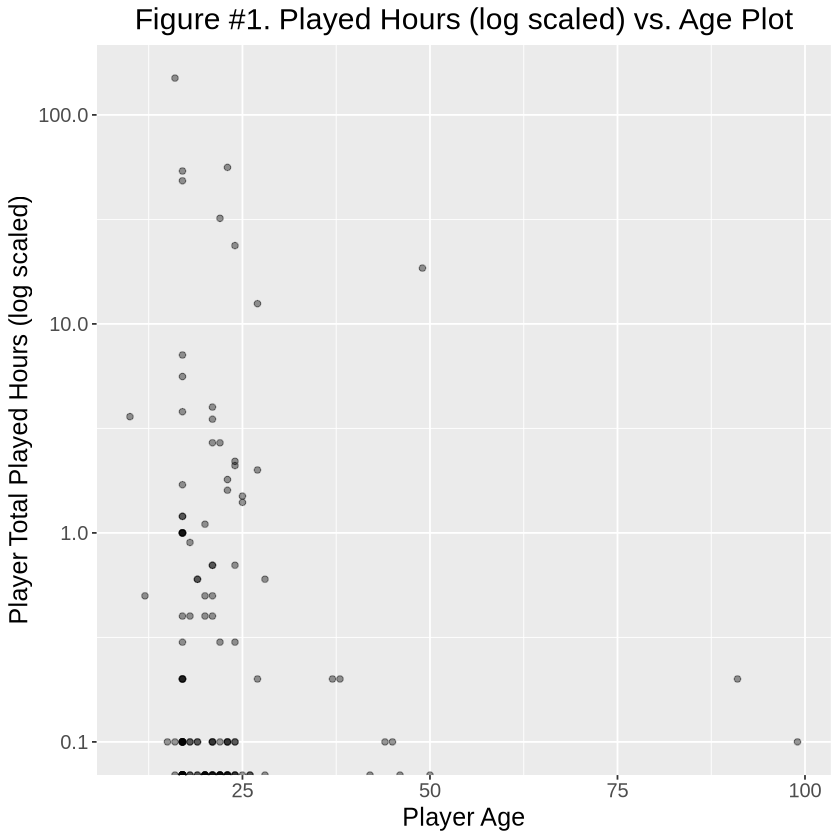

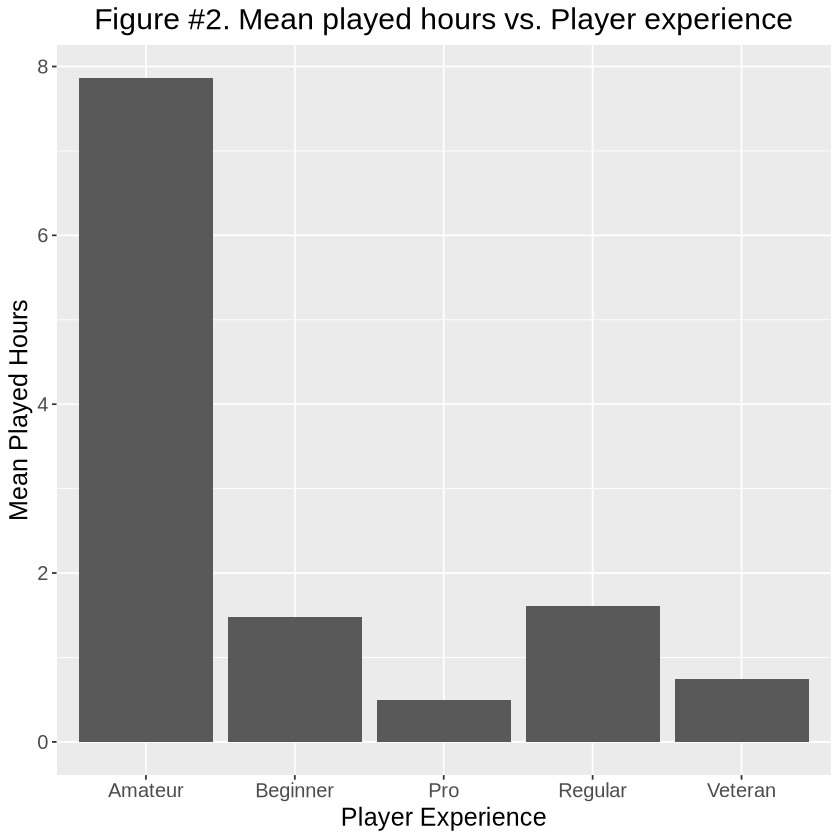

In [6]:
set.seed(2020)

# split data to training and testing


player_split <- initial_split(player_data, prop = 0.75, strata = played_hours)
player_train <- training(player_split)
player_test <- testing(player_split)

# making visualizations for pre-predictions
       
played_hours_vs_age_plot <- player_train |>
                        ggplot(aes(x=age, y=played_hours)) +
                        geom_point(alpha=0.4) +
                        labs(x="Player Age", y= "Player Total Played Hours (log scaled)") +
                        ggtitle("Figure #1. Played Hours (log scaled) vs. Age Plot") +
                        theme(text = element_text(size = 15), 
                             plot.title = element_text(hjust = 0.5)) +
                        scale_y_log10()

played_hours_vs_age_plot 



mean_played_hours_and_experience <- group_by(player_train, experience) |>
                                    summarize(mean_played_hours = mean(played_hours))
                            
mean_played_hours_and_experience


mean_played_hours_vs_experience_bar <- ggplot(mean_played_hours_and_experience, aes(x=experience, y= mean_played_hours)) +
                    		geom_bar(stat= "identity") +
                            labs(x = "Player Experience",
                               y = "Mean Played Hours",
                              title = "Figure #2. Mean played hours vs. Player experience") +
                              theme(text = element_text(size = 15), 
                                   plot.title = element_text(hjust = 0.5))
mean_played_hours_vs_experience_bar                        


In this step, we are building and evaluating a k-nearest neighbors (KNN) regression model to predict played_hours based on age and experience_num from the training data. We start by defining a preprocessing recipe that scales and centers the predictors, ensuring they are on comparable scales. The model is specified using nearest_neighbor with a rectangular distance weighting function, leaving the number of neighbors (neighbors) as a tunable parameter to be optimized. To evaluate the model's performance, we use 10-fold cross-validation with stratification based on played_hours, splitting the training data into 10 subsets to ensure robust and reliable performance metrics.

Next, we create a workflow by combining the recipe and model specification, which is then used to perform a grid search to tune the number of neighbors. We test values from 1 to 100 for neighbors, and for each value, we calculate the root mean squared error (RMSE) through cross-validation. The results are collected and filtered to focus on RMSE, which is then visualized in a plot showing the relationship between the number of neighbors and the model's RMSE. This plot helps us understand how different values of neighbors affect the prediction accuracy.

Finally, we identify the optimal number of neighbors (k) that minimizes the RMSE, selecting the best-performing model. This process ensures that we determine the most effective configuration for the KNN model, striking the right balance between underfitting and overfitting to accurately predict played_hours.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,14.87241,10,4.451928,Preprocessor1_Model001
2,rmse,standard,13.23522,10,3.569252,Preprocessor1_Model002
3,rmse,standard,12.46110,10,3.547146,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
98,rmse,standard,11.21824,10,3.541423,Preprocessor1_Model098
99,rmse,standard,11.17977,10,3.549598,Preprocessor1_Model099
100,rmse,standard,11.17319,10,3.552594,Preprocessor1_Model100


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,rmse,standard,11.13129,10,3.397325,Preprocessor1_Model014


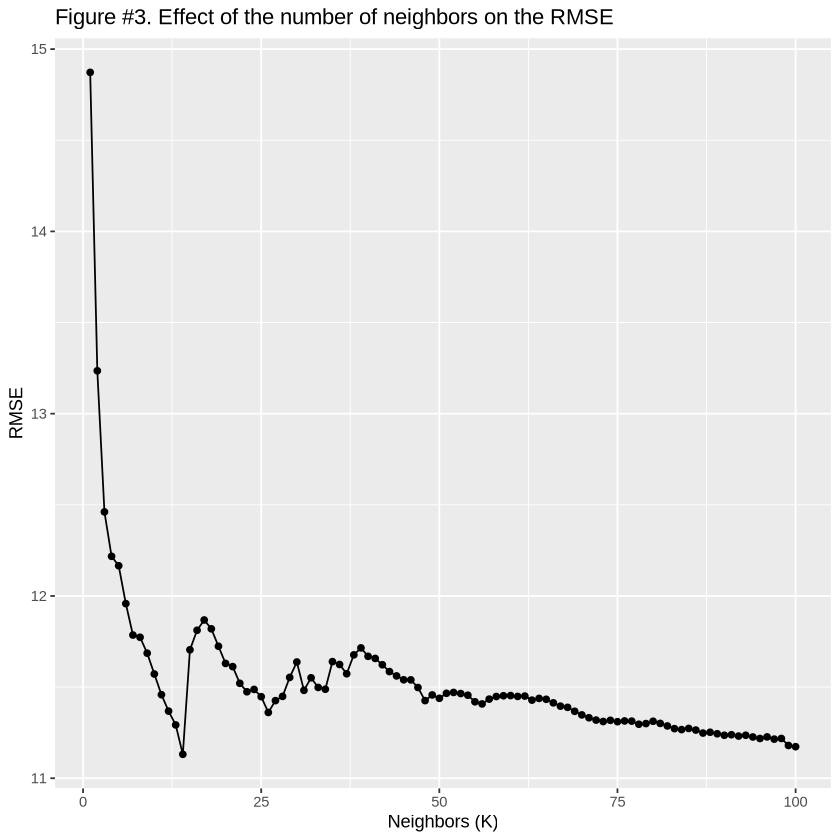

In [7]:
set.seed(2020)

# creating recipe of model

player_recipe <- recipe(played_hours ~ age + experience_num, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 

# creating specification for model (selecting engine and mode)

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                              set_engine("kknn") |>
                              set_mode("regression")

# preparing our folds and workflow

player_vfold <- vfold_cv(player_train, v = 10, strata = played_hours) #10-fold validation, feel free to increase to a higher one if it's better

player_wkflw <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_spec)


gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1)) #This runs cross validation for a grid of numbers of neighbors ranging from 1 to 125, going up by 1 each time

# collecting metrics after we tune our model

player_results <- player_wkflw |>
  tune_grid(resamples = player_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

player_results

# visualizing the mean RMSE vs. K relationship to select our best k value (lowest mean RMSE)

kvalues_plot <- player_results |> 
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors (K)", y = "RMSE", title = "Figure #3. Effect of the number of neighbors on the RMSE")

kvalues_plot


player_min <- player_results |>
  filter(mean == min(mean))

player_min

Using the optimal k value that we found of k=14 (kmin in the code) identified during cross-validation, we evaluated the KNN regression model on the testing dataset. We created a finalized model specification, trained it on the player_train data using the original preprocessing recipe, and then generated predictions on player_test. These predictions were compared to the actual values in the test set, and we calculated the root mean squared prediction error (RMSPE) to assess the model's accuracy on unseen data. This step ensures that the model generalizes well and maintains predictive performance beyond the training dataset.

In [15]:
set.seed(2020)

# here we evaluate our model using our best K value 
# steps for the recipe, spec, etc. are the same as before except that we do not need to tune

kmin <- player_min |> pull(neighbors)

player_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

player_best_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_best_spec) |>
  fit(data = player_train)

player_summary <- player_best_fit  |>
  predict(player_test) |>
  bind_cols(player_test) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

player_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,50.91299


Using the optimal k value of k=14, our model achieved an RMSPE of 50.913 on the testing set. This relatively high error suggests that the variables we used, age and experience_num, may not be strong predictors of played_hours. While these factors might contribute some explanatory power, the results indicate that additional or alternative variables may be necessary to improve the model's accuracy and predictive performance. This highlights the need for further exploration of other potential predictors that could better capture the factors influencing total hours played.

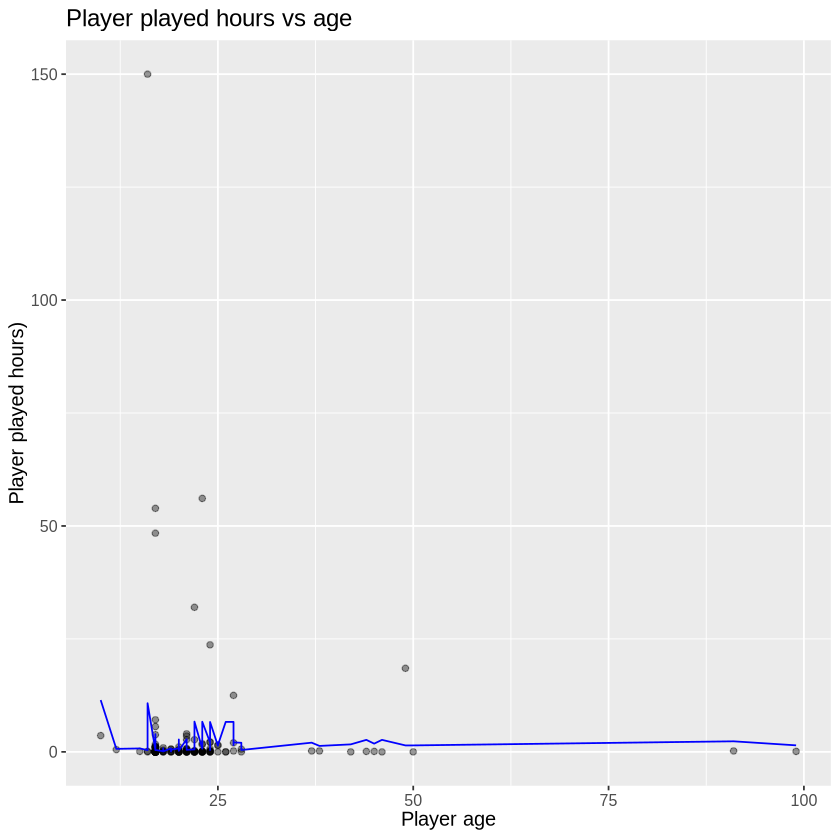

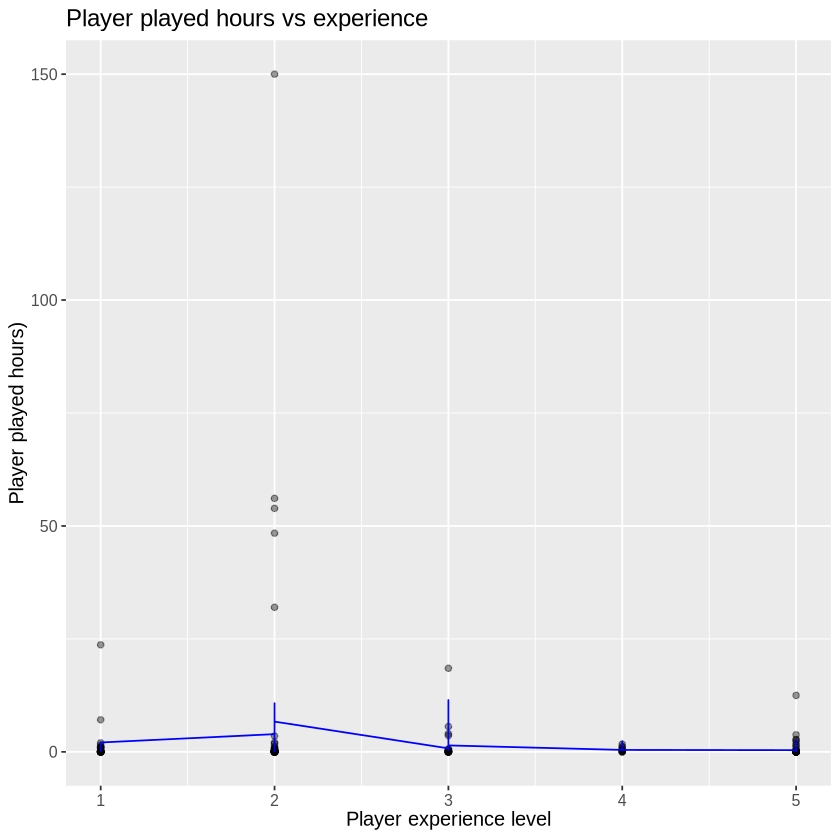

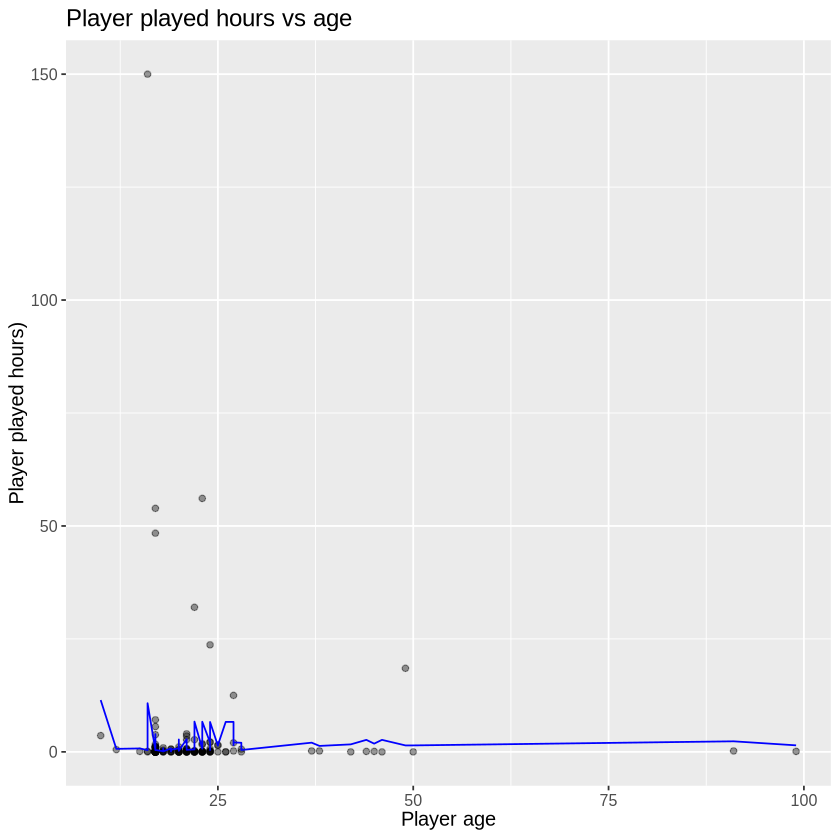

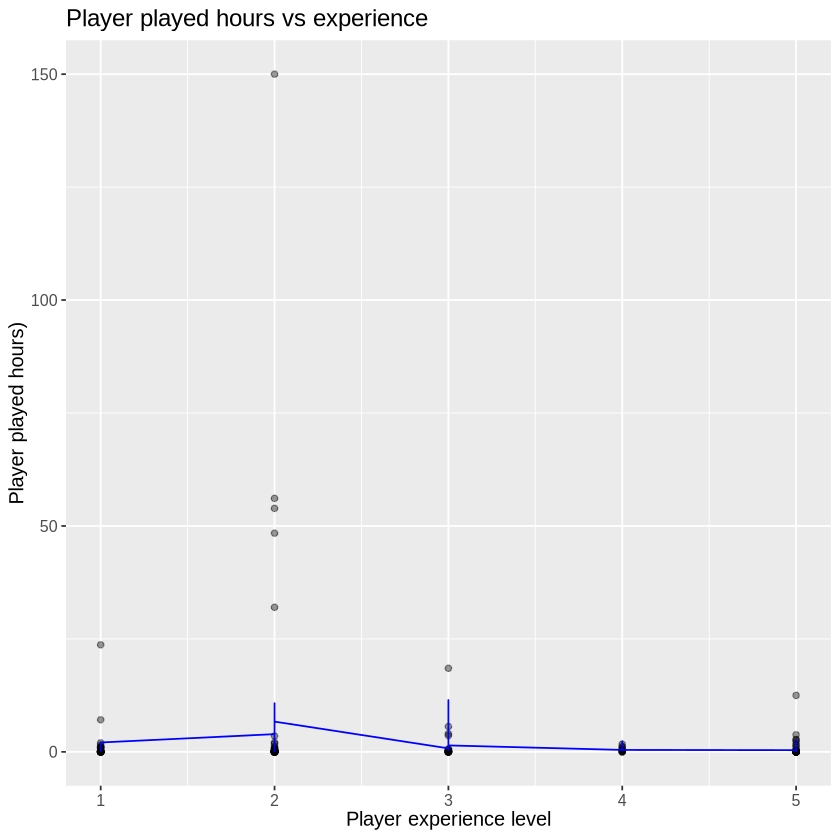

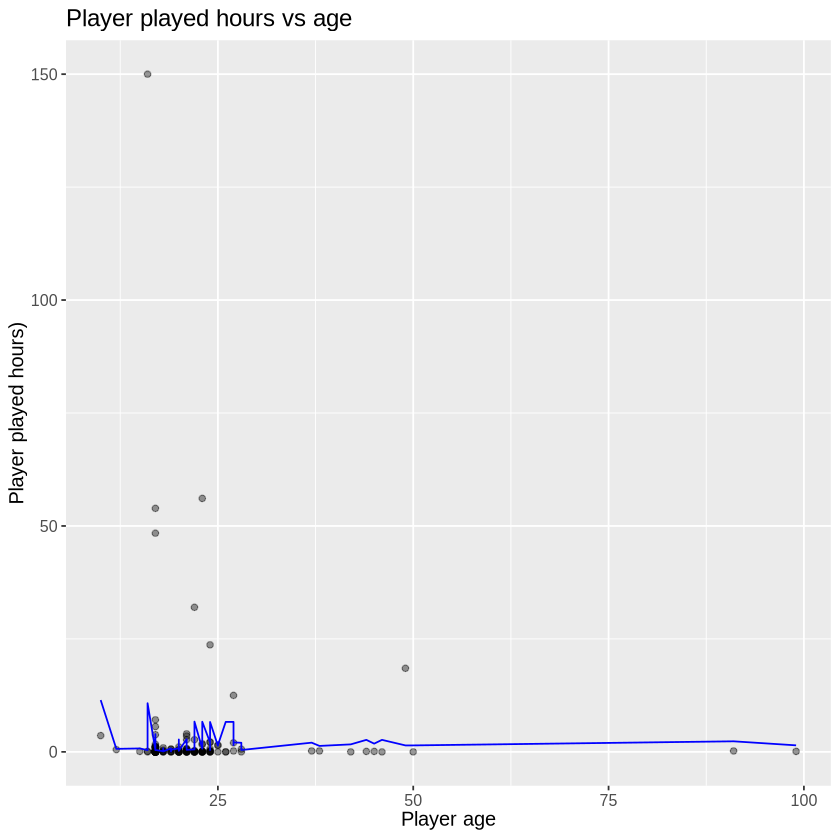

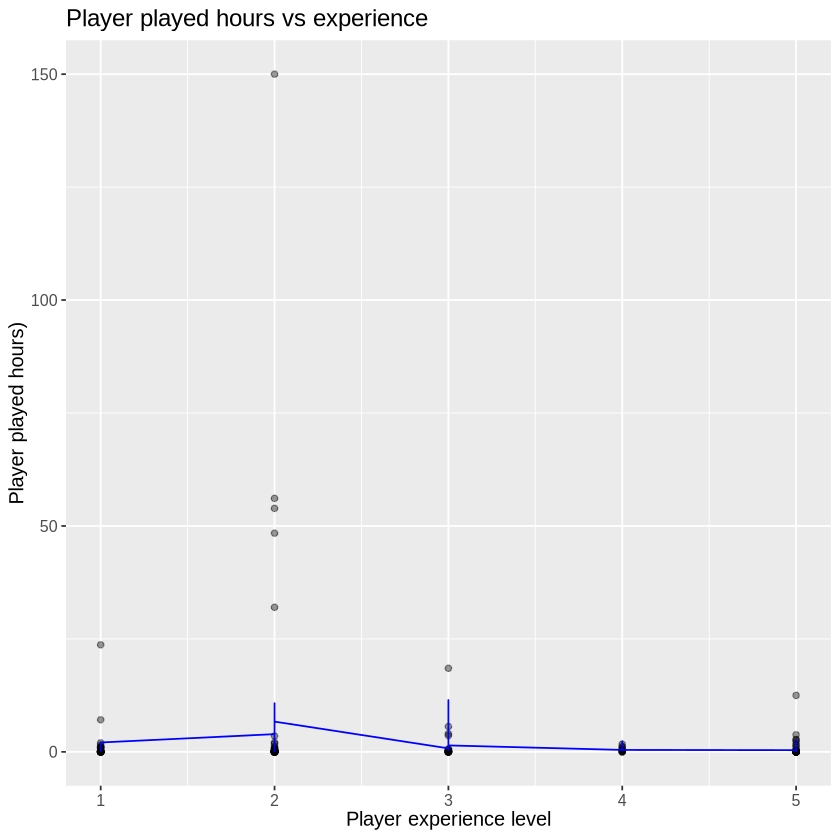

In [21]:
player_preds <- player_best_fit |>
                  predict(player_train) |>
                  bind_cols(player_train)

player_plot <- ggplot(player_preds, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = player_preds,
            mapping = aes(x = age, y = .pred),
            color = "blue") +
  xlab("Player age") +
  ylab("Player played hours)") +
  ggtitle("Player played hours vs age") +
  theme(text = element_text(size = 12))

player_plot #change the name for the plot

player_plot_2 <- ggplot(player_preds, aes(x = experience_num, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = player_preds,
            mapping = aes(x = experience_num, y = .pred),
            color = "blue") +
  xlab("Player experience level") +
  ylab("Player played hours)") +
  ggtitle("Player played hours vs experience") +
  theme(text = element_text(size = 12))

player_plot_2 #change the name for the plot + maybe even try to zoom in a little more to see the details of the line better

player_preds_2 <- player_best_fit |>
                  predict(player_test) |>
                  bind_cols(player_test)

player_plot_3 <- ggplot(player_preds, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = player_preds,
            mapping = aes(x = age, y = .pred),
            color = "blue") +
  xlab("Player age") +
  ylab("Player played hours)") +
  ggtitle("Player played hours vs age") +
  theme(text = element_text(size = 12))

player_plot_3 #change the name for the plot

player_plot_4 <- ggplot(player_preds, aes(x = experience_num, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = player_preds,
            mapping = aes(x = experience_num, y = .pred),
            color = "blue") +
  xlab("Player experience level") +
  ylab("Player played hours)") +
  ggtitle("Player played hours vs experience") +
  theme(text = element_text(size = 12))

player_plot_4 #change the name for the plot 

player_preds_3 <- player_best_fit |>
                  predict(player_data) |>
                  bind_cols(player_data)

player_plot_5 <- ggplot(player_preds, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = player_preds,
            mapping = aes(x = age, y = .pred),
            color = "blue") +
  xlab("Player age") +
  ylab("Player played hours)") +
  ggtitle("Player played hours vs age") +
  theme(text = element_text(size = 12))

player_plot_5 #change the name for the plot

player_plot_6 <- ggplot(player_preds, aes(x = experience_num, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = player_preds,
            mapping = aes(x = experience_num, y = .pred),
            color = "blue") +
  xlab("Player experience level") +
  ylab("Player played hours)") +
  ggtitle("Player played hours vs experience") +
  theme(text = element_text(size = 12))

player_plot_6 #change the name for the plot 